# VLE Modeling of Ethyl Acetate–Methanol via NRTL Parameter Estimation and Residual Multilayer Perceptron (MLP) Neural Network Correction

## Overview

The experimental **VLE data for the ethyl acetate–methanol system** were validated using the van Ness point-to-point consistency test. Group-contribution baselines (UNIFAC and ASOG) were computed to provide parameter-independent estimates of activity coefficients for comparison. In this study, the system was modeled with **NRTL** using literature parameters and refitted binary interaction parameters, alongside a **machine-learning residual multilayer perceptron (MLP)** that learns corrections to the NRTL+Raoult vapor-phase composition. Consequently, the models' accuracies were quantified against the experimental data using MAE, RMSE, and SMAPE.

## Objectives
1. To utilize NRTL model using literature binary interaction parameters g12 and g21 ang generate a baseline VLE.
2. To estimate the NRTL binary interaction parameters and generate a VLE prediction using the fitted values.
3. To train a residual neural network (MLP) to adjust the NRTL baseline vapor-phase composition and generate a hybrid NRTL–NN prediction.
4. To compare Baseline, Fitted, and NRTL-NN predictions using MAE, RMSE, and SMAPE

# Libraries Import

- Imports core packages
- Sets global constants and plotting style (matplotlib only)

In [12]:
import math, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from thermo import Chemical

from dataclasses import dataclass
from typing import Tuple, Dict

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

from scipy.optimize import minimize

R = 8.314462618  # J/mol/K

# ETL (Extract, Transform, and Load)

- Importing dataset which contains the experimental data
- Renames 'y2' to 'gamma2' because the paper's table column is γ2
- Adds constant pressure column P_kPa = 300 (0.3 MPa dataset)

In [13]:
CSV_PATH = "ethyl_acetate_methanol_vle.csv"  # change if your file is elsewhere

df = pd.read_csv(CSV_PATH)

# Renaming column
if "y2" in df.columns and "gamma2" not in df.columns:
    df = df.rename(columns={"y2": "gamma2"})

# Safety checks
expected = {"T_K","x1","y1"}
missing = expected - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Pressure (0.3 MPa) for this dataset
if "P_kPa" not in df.columns:
    df["P_kPa"] = 300.0

# Derived
df["x2"] = 1.0 - df["x1"]
df.head()

,T_K,x1,y1,gamma2,P_kPa,x2
0,369.45,0.000,0.000,1.000,300.0,1.000
1,368.85,0.022,0.035,0.989,300.0,0.978
2,368.55,0.031,0.049,0.993,300.0,0.969
3,368.15,0.044,0.063,1.005,300.0,0.956
4,367.65,0.077,0.102,1.014,300.0,0.923


# Psat(T): Antoine constants

- Uses the thermo package to get Psat(T) directly (in kPa)
- Component IDs: "ethyl acetate" and "methanol"

In [66]:
def Psat_kPa_component1(T_K: float) -> float:
    chem = Chemical("ethyl acetate", T=T_K)
    return chem.Psat/1000.0  # Pa → kPa

def Psat_kPa_component2(T_K: float) -> float:
    chem = Chemical("methanol", T=T_K)
    return chem.Psat/1000.0  # Pa → kPa

# NRTL (Baseline)

- Implements binary NRTL for γ1, γ2
- Uses data from Susial et al. (2012) where: alpha=0.47, g12=1124.6 J/mol, g21=2202.2 J/mol

In [79]:
@dataclass
class NRTLParams:
    alpha12: float
    alpha21: float
    g12: 1124.6      # J/mol
    g21: 2202.2      # J/mol

# Symmetric non-randomness (alpha12 = alpha21 = 0.47):
NRTL_DEFAULT = NRTLParams(alpha12=0.47, alpha21=0.47, g12=1124.6, g21=2202.2)

def nrtl_gammas(x1: float, T_K: float, p: NRTLParams) -> Tuple[float, float]:
    """
    Binary NRTL activity coefficients (standard closed form).
    Matches: ln G12 = -alpha12*tau12, ln G21 = -alpha21*tau21,
             tau12 = g12/(RT), tau21 = g21/(RT)
    """
    # Guard against endpoints to avoid division-by-zero
    x1 = float(np.clip(x1, 1e-12, 1.0 - 1e-12))
    x2 = 1.0 - x1

    tau12 = p.g12 / (R * T_K)
    tau21 = p.g21 / (R * T_K)
    G12 = math.exp(-p.alpha12 * tau12)
    G21 = math.exp(-p.alpha21 * tau21)

    S1 = x1 + x2 * G21
    S2 = x2 + x1 * G12

    # Textbook binary NRTL
    ln_gamma1 = (x2**2) * (tau21 * (G21 / S1)**2 + (tau12 * G12) / (S2**2))
    ln_gamma2 = (x1**2) * (tau12 * (G12 / S2)**2 + (tau21 * G21) / (S1**2))

    return math.exp(ln_gamma1), math.exp(ln_gamma2)

# Modified Raoult’s law

- Computes y1 from x1, T, P using γ from NRTL and Psat(T) from Antoine.

In [80]:
def predict_y1_row(x1: float, T_K: float, P_kPa: float, nrtl: NRTLParams) -> float:
    x2 = 1.0 - x1
    g1, g2 = nrtl_gammas(x1, T_K, nrtl)
    P1 = Psat_kPa_component1(T_K)
    P2 = Psat_kPa_component2(T_K)
    num1 = x1 * g1 * P1
    num2 = x2 * g2 * P2
    y1 = num1 / (num1 + num2 + 1e-16)
    return max(0.0, min(1.0, y1))

# Baseline predictions and metrics/plots

- Vectorizes y1 prediction over the dataframe.
- Computes MAE/RMSE/AARD%.
- Plots y–x and parity plots.


In [143]:
def eval_baseline(df_in: pd.DataFrame, nrtl: NRTLParams):
    df = df_in.copy()
    df["y1_calc_nrtl"] = [
        predict_y1_row(x, T, P, nrtl)
        for T, x, P in zip(df["T_K"], df["x1"], df["P_kPa"])
    ]

    y_true = df["y1"].to_numpy()
    y_pred = df["y1_calc_nrtl"].to_numpy()

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    aard = 100.0 * np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12)))

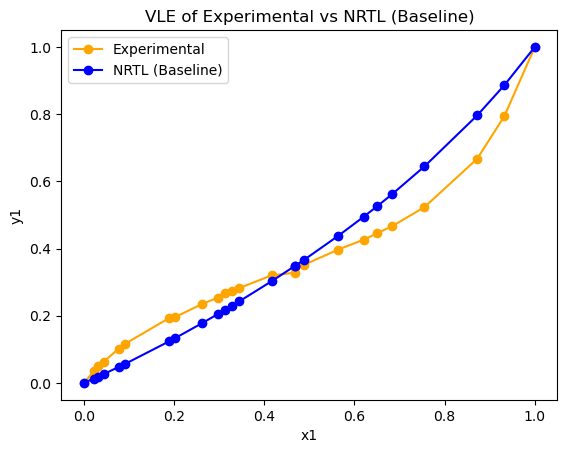

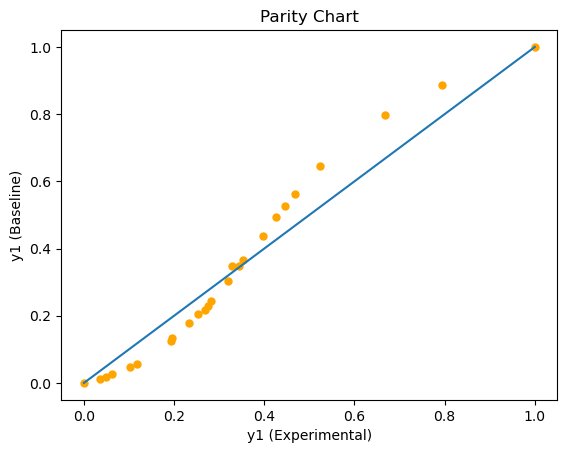

In [144]:
# Plots
plt.figure()
plt.plot(df["x1"], df["y1"], label="Experimental", color="orange", marker='o', linestyle='-')
plt.plot(df_pred["x1"], df_pred["y1_calc_nrtl"], label="NRTL (Baseline)", color="blue", marker='o', linestyle='-')
plt.xlabel("x1"); plt.ylabel("y1")
plt.title("VLE of Experimental vs NRTL (Baseline)")
plt.legend()
plt.show()

plt.figure()
plt.scatter(df_pred["y1"], df_pred["y1_calc_nrtl"], s=25, color="orange")
plt.plot([0,1],[0,1])
plt.xlabel("y1 (Experimental)"); plt.ylabel("y1 (Baseline)")
plt.title("Parity Chart")
plt.show()

# NRTL (Fitted)

- Estimates new values for g12, g21 but is based on alpha = 0.47 (Susial et al., 2012) to minimize SSE on y1.
- Prints fitted params and new metrics.

In [131]:
# Description:
# - Fits g12, g21 (alpha fixed) via L-BFGS-B on SSE of y1

def sse_for_params(theta: np.ndarray, df_local: pd.DataFrame, alpha: float) -> float:
    g12, g21 = theta
    p = NRTLParams(alpha=alpha, g12=g12, g21=g21)
    yhat = [predict_y1_row(x, T, P, p) for T, x, P in zip(df_local["T_K"], df_local["x1"], df_local["P_kPa"])]
    y = df_local["y1"].to_numpy()
    return float(np.sum((y - np.array(yhat))**2))

x0 = [2000, 3000]
bnds = [(100, 15000), (100, 15000)]

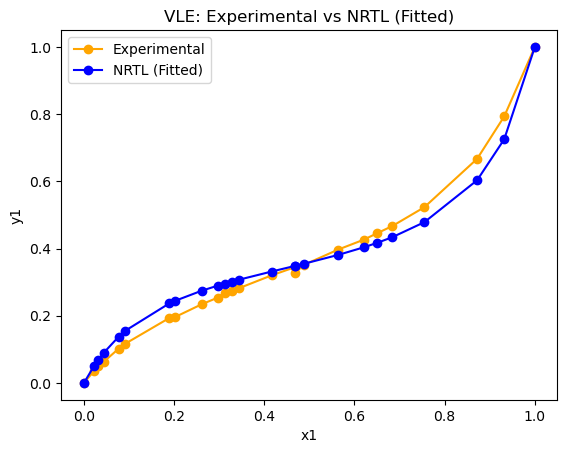

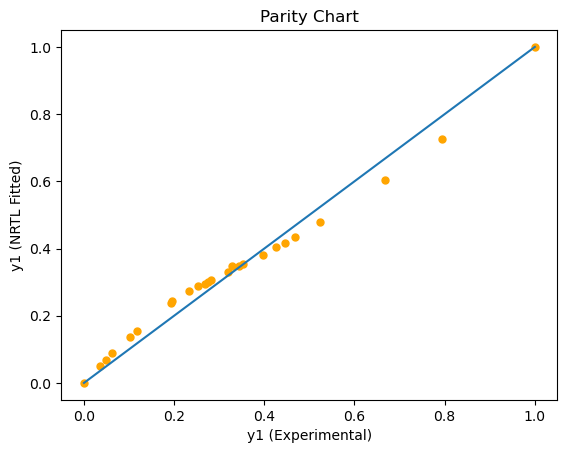

In [133]:
# Plot

# Sort for smooth lines
order = np.argsort(df["x1"].to_numpy())
x_sorted   = df["x1"].to_numpy()[order]
yexp_sorted= df["y1"].to_numpy()[order]
yfit_sorted= y_fit[order]

# Experimental (line+dots) vs NRTL (Fitted)
plt.figure()
plt.plot(x_sorted, yexp_sorted, label="Experimental", color="orange", marker='o', linestyle='-')
plt.plot(x_sorted, yfit_sorted, label="NRTL (Fitted)", color="blue", marker='o', linestyle='-')
plt.xlabel("x1"); plt.ylabel("y1")
plt.title("VLE: Experimental vs NRTL (Fitted)")
plt.legend(); plt.show()

# Parity plot using y_fit
plt.figure()
plt.scatter(df["y1"], y_fit, s=25, color="orange")
plt.plot([0,1],[0,1])
plt.xlabel("y1 (Experimental)"); plt.ylabel("y1 (NRTL Fitted)")
plt.title("Parity Chart")
plt.show()

# NRTL (Residual MLP)

- Learn residual Δy = y_exp - y0 where y0 = NRTL+Raoult prediction
- Inputs: [x1, T_K, P_kPa, y0, gamma1_NRTL, gamma2_NRTL]
- Model: scikit-learn MLPRegressor
- Evaluation: 5-fold CV; report MAE, RMSE, AARD% and plot vs baseline

In [84]:
def build_residual_features(df_in, nrtl_params):
    df0 = df_in.copy()
    # baseline y0 and NRTL gammas
    y0, g1_list, g2_list = [], [], []
    for T, x, P in zip(df0["T_K"], df0["x1"], df0["P_kPa"]):
        y0_i = predict_y1_row(x, T, P, nrtl_params)
        g1_i, g2_i = nrtl_gammas(x, T, nrtl_params)
        y0.append(y0_i); g1_list.append(g1_i); g2_list.append(g2_i)
    y0 = np.array(y0, dtype=np.float32)
    g1 = np.array(g1_list, dtype=np.float32)
    g2 = np.array(g2_list, dtype=np.float32)

    X = np.column_stack([
        df0["x1"].to_numpy(dtype=np.float32),
        df0["T_K"].to_numpy(dtype=np.float32),
        df0["P_kPa"].to_numpy(dtype=np.float32),
        y0, g1, g2
    ])
    y = df0["y1"].to_numpy(dtype=np.float32)
    return X, y, y0

# Build features/targets
X, y, y0 = build_residual_features(df, NRTL_DEFAULT)

# 5-fold CV fit of residuals
kf = KFold(n_splits=5, shuffle=True, random_state=42)
yhat_nn = np.zeros_like(y, dtype=np.float32)

for tr, te in kf.split(X):
    model = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(
            hidden_layer_sizes=(64, 64),
            activation="relu",
            alpha=1e-4,                # L2 regularization
            learning_rate_init=1e-3,
            max_iter=5000,
            early_stopping=True,
            n_iter_no_change=100,
            random_state=42
        ))
    ])
    # Train on residuals
    model.fit(X[tr], (y[tr] - y0[tr]))
    # Predict residuals and add back baseline
    res_pred = model.predict(X[te])
    yhat_nn[te] = np.clip(y0[te] + res_pred.astype(np.float32), 0.0, 1.0)

# Metrics vs experimental
mae   = mean_absolute_error(y, yhat_nn)
rmse  = root_mean_squared_error(y, yhat_nn)
aard  = 100.0 * np.mean(np.abs((y - yhat_nn) / (y + 1e-12)))

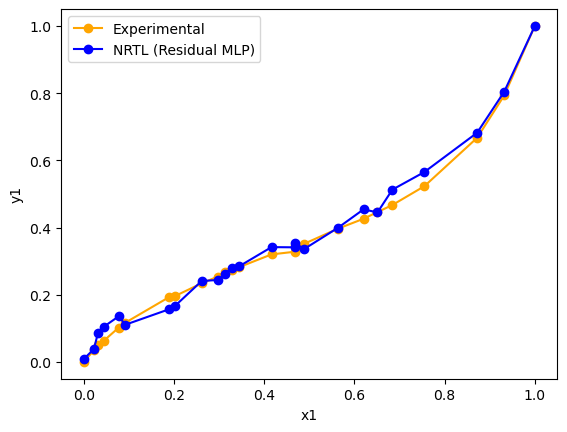

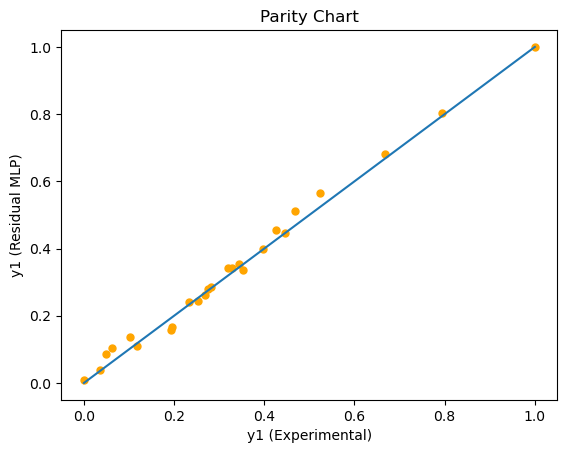

In [102]:
# Plot exp vs baseline vs residual-MLP
plt.figure()
plt.plot(df["x1"], df["y1"], label="Experimental", color="orange", marker='o', linestyle='-')
plt.plot(df["x1"], yhat_nn, label="NRTL (Residual MLP)", color="blue", marker='o', linestyle='-')
plt.xlabel("x1"); plt.ylabel("y1")
plt.legend()
plt.show()

# Parity plot
plt.figure()
plt.scatter(y, yhat_nn, s=25, color="orange")
plt.plot([0,1],[0,1])
plt.xlabel("y1 (Experimental)"); plt.ylabel("y1 (Residual MLP)")
plt.title("Parity Chart")
plt.show()

# Summary of Results

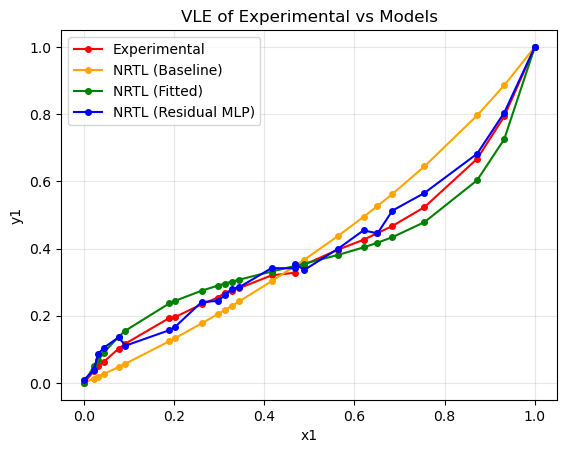

In [142]:
# Plot
plt.plot(df["x1"], df["y1"], label="Experimental", color="red", marker='o', markersize=4, linestyle='-')
plt.plot(df_pred["x1"], df_pred["y1_calc_nrtl"], label="NRTL (Baseline)", color="orange", marker='o', markersize=4, linestyle='-')
plt.plot(x_sorted, yfit_sorted, label="NRTL (Fitted)", color="green", marker='o', markersize=4, linestyle='-')
plt.plot(df["x1"], yhat_nn, label="NRTL (Residual MLP)", color="blue", marker='o', markersize=4, linestyle='-')

plt.xlabel("x1")
plt.ylabel("y1")
plt.title("VLE of Experimental vs Models")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [149]:
def smape_percent(y_true, y_pred, epsilon=1e-10):
    denominator = np.abs(y_true) + np.abs(y_pred) + epsilon
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / denominator
    )

def compute_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": root_mean_squared_error(y_true, y_pred),
        "SMAPE%": smape_percent(y_true, y_pred),
        "SSE": np.sum((y_true - y_pred) ** 2),
    }

y_exp = df["y1"].to_numpy()

# NRTL (Baseline)
try:
    y_base = df_pred["y1_calc_nrtl"].to_numpy()
except Exception:
    y_base = np.array([
        predict_y1_row(x, T, P, NRTL_DEFAULT)
        for T, x, P in zip(df["T_K"], df["x1"], df["P_kPa"])
    ])

rows = [("Baseline (NRTL)", compute_metrics(y_exp, y_base))]

# NRTL (Fitted)
try:
    p_fit = NRTLParams(
        alpha12=NRTL_DEFAULT.alpha12,
        alpha21=NRTL_DEFAULT.alpha21,
        g12=g12_fit,
        g21=g21_fit
    )
    y_fit = np.array([
        predict_y1_row(x, T, P, p_fit)
        for T, x, P in zip(df["T_K"], df["x1"], df["P_kPa"])
    ])
    rows.append(("NRTL (Fitted)", compute_metrics(y_exp, y_fit)))
except NameError:
    pass  # g12_fit/g21_fit not defined yet

# NRTL (Residual MLP)
if "yhat_nn" in globals():
    rows.append(("NRTL (Residual MLP)", compute_metrics(y_exp, yhat_nn)))

# Summary DataFrame
summary_df = pd.DataFrame(
    [(name, m["MAE"], m["RMSE"], m["SMAPE%"], m["SSE"]) for name, m in rows],
    columns=["Model", "MAE", "RMSE", "SMAPE%", "SSE"]
)

display(
    summary_df.style.format({
        "MAE": "{:.4f}",
        "RMSE": "{:.4f}",
        "SMAPE%": "{:.2f}",
        "SSE": "{:.4f}"
    })
)

,Model,MAE,RMSE,SMAPE%,SSE
0,Baseline (NRTL),0.0505,0.0609,28.66,0.0927
1,NRTL (Fitted),0.0278,0.0330,12.80,0.0272
2,NRTL (Residual MLP),0.0173,0.0226,17.65,0.0127


### Interpretation of Results

#### Experimental vs. models: 
- The experimental points form a smooth, convex VLE curve. All three models reproduce the overall shape and the correct limits at very low and very high x1

#### Baseline NRTL (g12 and g21 specified)
- Captures the trend but tends to overpredict y1 at medium–high x1
    
#### Fitted NRTL (re-estimated g12 and g21 with α fixed)
- Moves the curve slightly closer to the data; the data improved significantly but can't still capture the experimental data
    
#### NRTL + Residual Neural Network (MLP)
- Learns the remaining error of the NRTL prediction and adds a correction. This hybrid follows the experimental points more closely across most compositions.
    
#### Implications
- Baseline NRTL provides a sound thermodynamic reference.
- Fitting reduces bias but only slightly.
- The hybrid NRTL + NN delivers the best accuracy for interpolation within the data’s temperature/condition range. But, it should not be extrapolated beyond that range without additional data or retraining.

In [150]:
# Save Modeling Prediction in CSV File

# Create a DataFrame with all results
results_df = pd.DataFrame({
    "x1_exp": df["x1"],
    "y1_exp": df["y1"],
    "x1_baseline": df_pred["x1"],
    "y1_baseline": df_pred["y1_calc_nrtl"],
    "x1_fitted": x_sorted,
    "y1_fitted": yfit_sorted,
    "x1_nn": df["x1"],
    "y1_nn": yhat_nn
})

# Save to CSV
results_df.to_csv("[G03] Model Results.csv", index=False)

print("Results saved to [G03] Model Results.csv")

Results saved to [G03] Model Results.csv
